In [21]:
import numpy as np
from cvxopt import solvers, matrix, sparse
import matplotlib.pyplot as plt
#from scipy import sparse
%matplotlib inline
import sys, os
old_stdout = sys.stdout 
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore
def enablePrint():
    sys.stdout = old_stdout


In [200]:
'''
MATLAB version of the Poisson FD matrix
kk = @(i,j) (j-1) * m + i;            % local-to-global grid index formula
N = m^2;  A = sparse(N,N);  F = zeros(N,1);
for i = 1:m
    for j = 1:m
       k = kk(i,j);
       A(k,k) = -4.0;
       if i > 1,    A(k,kk(i-1,j)) = 1.0;    end
       if i < m,    A(k,kk(i+1,j)) = 1.0;    end
       if j > 1,    A(k,kk(i,j-1)) = 1.0;    end
       if j < m,    A(k,kk(i,j+1)) = 1.0;    end
       
    end
end
A = (1.0 / h^2) * A;
'''
#F(k) = f(x(i),y(j));
def obstacle2D(psi, m, f):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
    A = np.zeros((2*N + 2*m,2*N))
    F = np.zeros((2*N,1))
    P = np.zeros((2*N,1))
    Uk = np.zeros((2*N,1))
    B = np.zeros((N,2*N))
    T = np.zeros((m+1,m))
    T[0,0] = 1.0
    T[m,m-1] = -1.0
    for i in range(1,m):
        T[i,i-1] = -1.0
        T[i,i] = 1.0
    for i in range(0,2*m):
        A[i*(m+1):(i+1)*(m+1),i*m:(i+1)*m] = T
    A = A/h**2
    print(A)
    A = np.dot(np.transpose(A),A)
    for i in range(0,m):
        for j in range(0,m):
            B[i*m + j,i + j*m] = 1.0
    B[0:N,N:2*N] = -np.identity(N)
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            F[k + N] = f(X[j],X[i])
            P[k] = psi(X[i],X[j])
            P[k + N] = psi(X[j],X[i])
            Uk[k] = max(P[k],0.0)
            Uk[k + N] = max(P[k + N],0.0)
    print(B)
    return A, B, Uk, P, F, X

def obstacle2D(psi,m,f):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
    A = np.zeros((N,N))
    F = np.zeros((N,1))
    P = np.zeros((N,1))
    Uk = np.zeros((N,1))
    T = np.zeros((m,m))
    I = np.identity(m)
    F2 = np.zeros((N,1))
    Alpha = .68026
    Beta = .47152
    for i in range(1,m-1):
        T[i,i] = -4.0
        T[i,i-1] = 1.0
        T[i,i+1] = 1.0
    T[0,0] = -4.0
    T[0,1] = 1.0
    T[-1,-2] = 1.0
    T[-1,-1] = -4.0
    for i in range(1,m-1):
        A[i*m:(i+1)*m,i*m:(i+1)*m] = T
        A[i*m:(i+1)*m,(i+1)*m:m*(i+2)] = I
        A[i*m:(i+1)*m,m*(i-1):i*m] = I
    A[0:m,0:m] = T
    A[0:m,m:2*m] = I
    A[m*(m-1):N,m*(m-2):m*(m-1)] = I
    A[m*(m-1):N,m*(m-1):N] = T
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            P[k] = psi(X[i],X[j])
            Uk[k] = max(P[k],0.0)
            if j == 0:
                r = np.linalg.norm(np.array([X[i],-2.0]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if j == m - 1:
                r = np.linalg.norm(np.array([X[i],2.0]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if i%m == 0:
                r = np.linalg.norm(np.array([-2.0,X[j]]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if (i + 1)%m == 0:
                r = np.linalg.norm(np.array([2.0,X[j]]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
    print(F2)
    F = F - F2
    return A, Uk, P, F, X

def obstacleqp(psi, m, f, a = 0, b = 0):
  N = m**2
  A, Uk, P, F, X = obstacle2D(psi, m, f)
  plt.spy(A)
  sol = solvers.qp(matrix(-A),matrix(F),matrix(-np.identity(N)),matrix(-P),initvals = matrix(Uk))
  U = sol['x']
  enablePrint()
  return X, U
'''
def poissonBox(psi, m, f):
  h = 1/(m+1)
  kk = lambda i,j: j * m + i
  N = m**2
  A = np.zeros((N,N))
  F = np.zeros((N,1))
  P = np.zeros((N,1))
  Uk = np.zeros((N,1))
  X = np.linspace(-1.0 + 2*h,1.0 - 2*h,m)
  for j in range(0,m):
    for i in range(0,m):
        k = kk(i,j)
        A[k,k] = -4.0
        if i > 0: 
             A[k,kk(i,j-1)] = 1.0
        if i < m - 1:
            A[k,kk(i,j-1)] = 1.0
        if j > 0:
            try:
                A[k,kk(i,j+1)] = 1.0
            except IndexError:
                    print(k, kk(i,j+1))
        if j < m - 1:
                A[k,kk(i,j+1)] = 1.0
        F[k] = f(X[i],X[j])
        P[k] = psi(X[i],X[j])
        Uk[k] = max(P[k],0.0)
  A = A/h**2
  return A, Uk, F, P, X

import numpy as np
from cvxopt import solvers, matrix

def obstacleqp(psi, m, f, a = 0, b = 0):
  N = m**2
  A, Uk, F, P, X = poissonBox(psi, m, f)
  A = np.dot(np.transpose(A),A)
  sol = solvers.qp(matrix(A),matrix(F),matrix(-np.identity(N)),matrix(-P))
  U = sol['x']
  enablePrint()
  return X, U
'''
f = lambda x,y: x*0
psi = lambda x,y: np.sqrt(np.maximum(0.0,1 - x**2 - y**2)) + np.minimum(0.0,1-x**2-y**2)
# = lambda x,y: 5 - np.sin(14*x)# - np.sin(14*y)

[[-0.44485108]
 [-0.2091126 ]
 [-0.19584599]
 ..., 
 [-0.19584599]
 [-0.2091126 ]
 [-0.44485108]]
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -3.8207e+03  2e+03  8e-01  3e+01
 1:  3.3662e+01 -2.1793e+03  2e+03  4e-01  2e+01
 2:  3.0171e+01 -5.9335e+02  6e+02  1e-01  5e+00
 3:  9.6708e+00 -1.1673e+02  1e+02  2e-02  9e-01
 4:  3.4747e+00 -2.5645e+00  6e+00  2e-04  8e-03
 5:  8.8418e-01  4.7322e-01  4e-01  2e-06  8e-05
 6:  7.2100e-01  6.6480e-01  6e-02  2e-07  8e-06
 7:  7.0848e-01  6.9932e-01  9e-03  2e-08  9e-07
 8:  7.0710e-01  7.0635e-01  7e-04  1e-09  5e-08
 9:  7.0700e-01  7.0698e-01  2e-05  2e-11  8e-10
10:  7.0700e-01  7.0700e-01  4e-07  2e-13  9e-12
Optimal solution found.


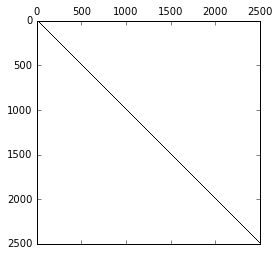

In [201]:
m = 50
h = 1/(m+1)
enablePrint()
X, U1 = obstacleqp(psi, m, f)

#print(U1)

norm = [ 0.00110906] 1234
0.705959462906
0.724616258987
0.715287860946


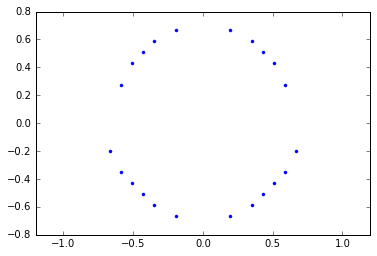

In [210]:
m = 50
h = 1/(m+1)
X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
Z1 = Z
kk = lambda i,j: j * m + i
uexact = np.zeros((N,1))
alpha = .68026
beta = .47152
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U1[kk(i,j)]
        r = np.sqrt(X[i]**2 + X[j]**2)
        if r > .69797:
            uexact[kk(i,j)] = -alpha*np.log(r) + beta
        else:
            uexact[kk(i,j)] = psi(X[i],X[j])
        Z1[i,j] = uexact[kk(i,j)]
#print(uexact[1000:1500] - U1[1000:1500])
print('norm =',max(list(abs(uexact - U1))),np.argmax(list(abs(uexact - U1))))
#print(uexact, U1)
x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x1, y1, z1, A1, rmax = area(x,y,z,m)
plt.plot(x1,y1,'.')
plt.axis('equal') 

A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U1[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-2:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x2, y2, z2, A2, rmax2 = area(x,y,z,m)
a = np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)])
b = np.mean([rmax,rmax2])
print(np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)]))
print(np.mean([rmax,rmax2]))
print(np.mean([a,b]))



[0.7543287867322096, 0.74612931727217446, 0.74612931727217446, 0.7543287867322096, 0.75432878673220971, 0.72097162003334259, 0.69490373124193539, 0.67696770594635569, 0.66781907317358447, 0.66781907317358435, 0.67696770594635569, 0.69490373124193539, 0.72097162003334259, 0.75432878673220971, 0.72945393089169708, 0.6859943405700355, 0.64913511204889607, 0.62005444317027059, 0.59988464865797475, 0.58954103444599648, 0.58954103444599648, 0.59988464865797475, 0.6200544431702707, 0.64913511204889607, 0.6859943405700355, 0.72945393089169697, 0.72097162003334248, 0.66781907317358435, 0.62005444317027048, 0.5790126690287607, 0.5462113049876125, 0.52320251231867965, 0.51130999256491361, 0.5113099925649135, 0.52320251231867965, 0.54621130498761261, 0.5790126690287607, 0.62005444317027048, 0.66781907317358413, 0.72097162003334248, 0.72945393089169708, 0.66781907317358435, 0.61005290925898226, 0.55735962366870184, 0.51130999256491361, 0.47384494014096362, 0.44712761768593651, 0.43315141243871613, 

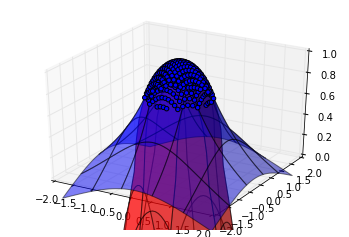

In [211]:
from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)

surf2 = ax.plot_surface(A,B,Z1,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(0,1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
print([np.linalg.norm(np.array([x[i],y[i]])) for i in range(0,len(x))])


In [203]:
#f = lambda x,y: x*0
#psi = lambda x,y: 5 - 20*x**2 - 20*y**2

def obstacle2D(psi,m,f):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
    A = np.zeros((N,N))
    F = np.zeros((N,1))
    P = np.zeros((N,1))
    Uk = np.zeros((N,1))
    T = np.zeros((m,m))
    I = np.identity(m)
    F2 = np.zeros((N,1))
    Alpha = .68026
    Beta = .47152
    for i in range(1,m-1):
        T[i,i] = -4.0
        T[i,i-1] = 1.0
        T[i,i+1] = 1.0
    T[0,0] = -4.0
    T[0,1] = 1.0
    T[-1,-2] = 1.0
    T[-1,-1] = -4.0
    for i in range(1,m-1):
        A[i*m:(i+1)*m,i*m:(i+1)*m] = T
        A[i*m:(i+1)*m,(i+1)*m:m*(i+2)] = I
        A[i*m:(i+1)*m,m*(i-1):i*m] = I
    A[0:m,0:m] = T
    A[0:m,m:2*m] = I
    A[m*(m-1):N,m*(m-2):m*(m-1)] = I
    A[m*(m-1):N,m*(m-1):N] = T
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            P[k] = psi(X[i],X[j])
            Uk[k] = max(P[k],0.0)
            if j == 0:
                r = np.linalg.norm(np.array([X[i],-2.0]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if j == m - 1:
                r = np.linalg.norm(np.array([X[i],2.0]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if i%m == 0:
                r = np.linalg.norm(np.array([-2.0,X[j]]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
            if (i + 1)%m == 0:
                r = np.linalg.norm(np.array([2.0,X[j]]))
                F2[k] = F2[k] + -Alpha*np.log(r) + Beta
    print(F2)
    F = F - F2
    return A, Uk, P, F, X



def reducedspace2(psi,m,f):
    A, Uk, P, F, X = obstacle2D(psi,m,f)
    L = lambda U: np.dot(-A,U + P) + F
    dL = lambda U: -A
    enablePrint()
    U, errlist = reducedspace(L,dL,Uk,10**-8)
    return X, U + P

def Fomega(A,x):
    n = len(x)
    y = np.zeros((n,1))
    y[[x > 0]] = A[[x > 0]]
    y[[x <= 0]] = np.minimum(A[[x <= 0]],0.0)
    '''
    for i in range(0,n):
        if x[i] > 0:
            y[i] = A[i]
        else:
            y[i] = min(A[i],0)
    '''
    return y

def pi(x):
    y = x
    y[[x < 0]] = 0
    return y

def reducedspace(F,gradF,x0,tol,exact = True,sigma = 10**-4, beta = .5, gamma = 10**-12):
    errlist = []
    n = len(x0)
    k = 0
    xk = x0
    A = F(xk)
    FO = Fomega(A,xk)
    pik = pi(x0)
    while np.linalg.norm(FO) > tol and k < 100:
        '''
        if type(exact) != bool:
            err = np.linalg.norm(exact - xk)
            errlist.append(err)
        '''
        k += 1
        print(k,xk)
        Axk = []
        Ixk = []
        for i in range(0,n):
            if xk[i] == 0 and A[i] > 0:
                Axk.append(i)
            else:
                Ixk.append(i)
        d = np.zeros((n,1))
        temp = gradF(xk)
        m = len(Ixk)
        B = np.zeros((m,m))
        for i in range(0,m):
            for j in range(0,m):
                B[i,j] = temp[Ixk[i],Ixk[j]]   
        dIxk = np.linalg.solve(B,-A[Ixk])
        j = 0
        for i in Ixk:
            d[i] = dIxk[j]
            j += 1
        
        alpha = beta
        fail = False
        Ak = F(pik)
        while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
            pik = pi(xk + alpha*d)
            Ak = F(pik)
            alpha *= beta
            if alpha < gamma:
                fail = True
                break
        
        if fail:
            alpha = beta
            d = -F(xk)
            while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
                alpha = alpha*beta
                pik = pi(xk + alpha*d)
                Ak = F(pik)
            if beta < gamma:
                print('Could not provide sufficient decrease. Process terminated iteration',k)
                return xk
            
        xk = pik
        A = F(xk)
        FO = Fomega(A,xk)
    print('\n','xk =',xk,'\n','F(xk) =',F(xk),'\n','F(xk)*xk =',np.dot(np.transpose(F(xk)),xk))
    return xk, errlist


[[-0.44485108]
 [-0.2091126 ]
 [-0.19584599]
 ..., 
 [-0.19584599]
 [-0.2091126 ]
 [-0.44485108]]
1 [[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
2 [[ 2.5051626 ]
 [ 1.78147645]
 [ 1.53902499]
 ..., 
 [ 1.53902499]
 [ 1.78147645]
 [ 2.5051626 ]]
3 [[ 4.11659165]
 [ 3.38991018]
 [ 2.93936942]
 ..., 
 [ 2.93936942]
 [ 3.38991018]
 [ 4.11659165]]
4 [[ 5.03625061]
 [ 4.42201591]
 [ 3.9568141 ]
 ..., 
 [ 3.9568141 ]
 [ 4.42201591]
 [ 5.03625061]]
5 [[ 5.54476487]
 [ 5.03543835]
 [ 4.60795413]
 ..., 
 [ 4.60795413]
 [ 5.03543835]
 [ 5.54476487]]
6 [[ 5.82349894]
 [ 5.39110344]
 [ 5.00613881]
 ..., 
 [ 5.00613881]
 [ 5.39110344]
 [ 5.82349894]]
7 [[ 5.97650272]
 [ 5.59620948]
 [ 5.24590642]
 ..., 
 [ 5.24590642]
 [ 5.59620948]
 [ 5.97650272]]
8 [[ 6.06115027]
 [ 5.71505381]
 [ 5.39014705]
 ..., 
 [ 5.39014705]
 [ 5.71505381]
 [ 6.06115027]]
9 [[ 6.10858469]
 [ 5.78469727]
 [ 5.47756843]
 ..., 
 [ 5.47756843]
 [ 5.78469727]
 [ 6.10858469]]
10 [[ 6.13562277]
 [ 5.82616074]
 [ 5.53122871]
 .

(-2, 2)

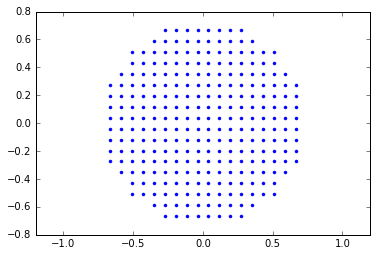

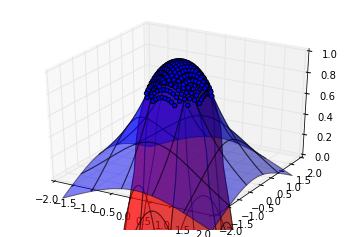

In [206]:
f = lambda x,y: x*0
psi = lambda x,y: np.sqrt(np.maximum(0.0,1 - x**2 - y**2)) + np.minimum(0.0,1-x**2-y**2)

m = 50
X, U = reducedspace2(psi,m,f)

h = 1/(m+1)
A,B = np.meshgrid(X,X)
C = psi(A,B)
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            x.append(-2.0 + 4*h*(i+1))
            y.append(-2.0 + 4*h*(j+1))
            z.append(Z[i,j])
plt.plot(x,y,'.')
plt.axis('equal')
N = m**2

from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(0,1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)

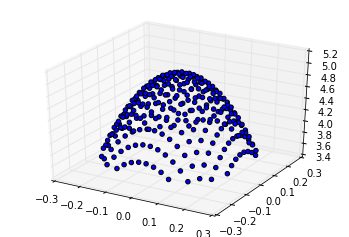

In [167]:
z = psi(np.array([x]),np.array([y]))
#surf = ax.plot_surface(np.array(x),np.array(y),z)
ax.set_zlim3d(-1,5)
fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
scatter2 = ax2.scatter(np.array([x]),np.array([y]),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')

norm = [ 0.00111006] 1234
0.713130638761
0.737650203383
0.720971620033
0.725390421072


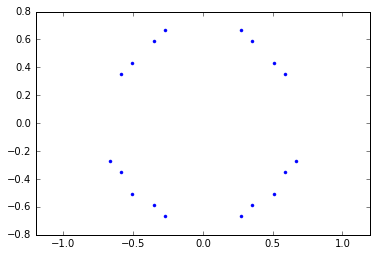

In [213]:
m = 50
h = 1/(m+1)
X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
uexact = np.zeros((N,1))
alpha = .68026
beta = .47152
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
        r = np.linalg.norm(np.array([X[i],X[j]]))
        if r > .69797:
            uexact[kk(i,j)] = -alpha*np.log(r) + beta
        else:
            uexact[kk(i,j)] = psi(X[i],X[j])
#print(uexact[1000:1500] - U1[1000:1500])
print('norm =',max(list(abs(uexact - U))),np.argmax(list(abs(uexact - U))))
x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x1, y1, z1, A1, rmax = area(x,y,z,m)
plt.plot(x1,y1,'.')
plt.axis('equal') 

A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-2:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x2, y2, z2, A2, rmax2 = area(x,y,z,m)
a = np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)])
b = np.mean([rmax,rmax2])
print(np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)]))
print(np.mean([rmax,rmax2]))
print(rmax)
print(np.mean([a,b]))

## print(max(list(abs(U - U1))))

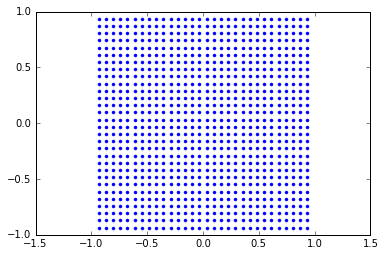

In [10]:
h = 1/(m+1)
A,B = np.meshgrid(X,X)
C = psi(A,B)
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            x.append(-1.0 + 2*h*(i+1))
            y.append(-1.0 + 2*h*(j+1))
            z.append(Z[i,j])
plt.plot(x,y,'.')
plt.axis('equal')
N = m**2

from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(-1,5)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)



(-1, 1)

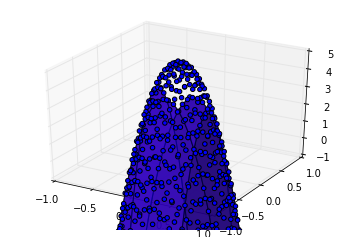

In [11]:
from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(-1,5)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)

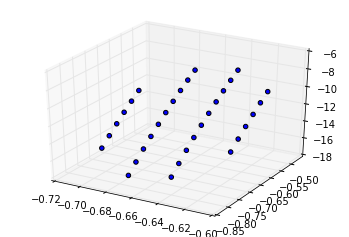

In [783]:
z = psi(np.array([x]),np.array([y]))
#surf = ax.plot_surface(np.array(x),np.array(y),z)
ax.set_zlim3d(-1,5)
fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
scatter2 = ax2.scatter(np.array([x]),np.array([y]),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')

In [671]:
def poissonBox(psi, m, f):
  h = 1/(m+1)
  kk = lambda i,j: j * m + i
  N = m**2
  A = np.zeros((N,N))
  F = np.zeros((N,1))
  P = np.zeros((N,1))
  Uk = np.zeros((N,1))
  X = np.linspace(-1.0 + 2*h,1.0 - 2*h,m)
  for i in range(0,N):
    A[i,i] = -4.0
    if i > 0:
        A[i,i-1] = 1.0
    if i < N - 1:
        A[i,i+1] = 1.0
    if i + 1 + m  < N:
        A[i,i + 1 + m] = 1.0
    if i - m - 1 > -1:
        A[i,i - m - 1] = 1.0
  for j in range(0,m):
    for i in range(0,m):
         k = kk(i,j)
         F[k] = f(X[i],X[j])
         P[k] = psi(X[i],X[j])
         Uk[k] = max(P[k],0.0)
  A = A/h**2
  return A, Uk, F, P, X


In [141]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def obstacle2D(psi,m,f):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(-1.0 + 2*h,1.0 - 2*h,m)
    A = np.zeros((N,N))
    F = np.zeros((N,1))
    P = np.zeros((N,1))
    Uk = np.zeros((N,1))
    T = np.zeros((m,m))
    I = np.identity(m)
    for i in range(1,m-1):
        T[i,i] = -4.0
        T[i,i-1] = 1.0
        T[i,i+1] = 1.0
    T[0,0] = -4.0
    T[0,1] = 1.0
    T[m-1,m-2] = 1.0
    T[m-1,m-1] = -4.0
    for i in range(1,m-1):
        A[i*m:(i+1)*m,i*m:(i+1)*m] = T
        A[i*m:(i+1)*m,(i+1)*m:m*(i+2)] = I
        A[i*m:(i+1)*m,m*(i-1):i*m] = I
    A[0:m,0:m] = T
    A[0:m,m:2*m] = I
    A[m*(m-1):N,m*(m-2):m*(m-1)] = I
    A[m*(m-1):N,m*(m-1):N] = T
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            P[k] = psi(X[i],X[j])
            Uk[k] = max(P[k],0.0)
    M = csr_matrix(A)
    return M, Uk, P, F, X


def reducedspace2(psi,m,f):
    M, Uk, P, F, X = obstacle2D(psi,m,f)
    L = lambda U: np.dot(-M,csr_matrix(U + P)) + csr_matrix(F)
    dL = lambda U: -M
    enablePrint()
    U, errlist = reducedspace(L,dL,Uk,10**-8)
    return X, U + P

def Fomega(A,x):
    n = len(x)
    y = np.zeros((n,1))
    y[[x > 0]] = A[[x > 0]]
    y[[x <= 0]] = np.minimum(A[[x <= 0]],0.0)
    '''
    for i in range(0,n):
        if x[i] > 0:
            y[i] = A[i]
        else:
            y[i] = min(A[i],0)
    '''
    return y

def pi(x):
    y = x
    y[[x < 0]] = 0
    return y

def reducedspace(F,gradF,x0,tol,exact = True,sigma = 10**-4, beta = .5, gamma = 10**-12):
    
    errlist = []
    n = len(x0)
    k = 0
    xk = x0
    A = F(xk)
    FO = Fomega(A,xk)
    pik = pi(x0)
    while np.linalg.norm(FO) > tol and k < 100:
        '''
        if type(exact) != bool:
            err = np.linalg.norm(exact - xk)
            errlist.append(err)
        '''
        k += 1
        print(k,xk)
        Axk = []
        Ixk = []
        for i in range(0,n):
            if xk[i] == 0 and A[i] > 0:
                Axk.append(i)
            else:
                Ixk.append(i)
        d = np.zeros((n,1))
        temp = gradF(xk)
        m = len(Ixk)
        B = np.zeros((m,m))
        for i in range(0,m):
            for j in range(0,m):
                B[i,j] = temp[Ixk[i],Ixk[j]]
        
        dIxk = spsolve(csr_matrix(B),-A[Ixk])
        j = 0
        for i in Ixk:
            d[i] = dIxk[j]
            j += 1
        
        alpha = beta
        fail = False
        Ak = F(pik)
        while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
            pik = pi(xk + alpha*d)
            Ak = F(pik)
            alpha *= beta
            if alpha < gamma:
                fail = True
                break
        
        if fail:
            alpha = beta
            d = -F(xk)
            while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
                alpha = alpha*beta
                pik = pi(xk + alpha*d)
                Ak = F(pik)
            if beta < gamma:
                print('Could not provide sufficient decrease. Process terminated iteration',k)
                return xk
            
        xk = pik
        A = F(xk)
        FO = Fomega(A,xk)
    print('\n','xk =',xk,'\n','F(xk) =',F(xk),'\n','F(xk)*xk =',np.dot(np.transpose(F(xk)),xk))
    return xk, errlist


In [142]:
m = 70
X, U = reducedspace2(psi,m,f)

h = 1/(m+1)
A,B = np.meshgrid(X,X)
C = psi(A,B)
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            x.append(-1.0 + 2*h*(i+1))
            y.append(-1.0 + 2*h*(j+1))
            z.append(Z[i,j])
plt.plot(x,y,'.')
plt.axis('equal')
N = m**2

from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(-1,5)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)


ValueError: setting an array element with a sequence.

In [ ]:
A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U1[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x1, y1, z1, A1, rmax = area(x,y,z,m)
plt.plot(x1,y1,'.')
plt.axis('equal') 

A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U1[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-2:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x2, y2, z2, A2, rmax2 = area(x,y,z,m)
a = np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)])
b = np.mean([rmax,rmax2])
print(np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)]))
print(np.mean([rmax,rmax2]))
print(np.mean([a,b]))